In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Transfer Learning

In [11]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [12]:
resnet_base_model = ResNet152V2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

resnet_base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']   

In [13]:
# transfer learning network

model_tl = Sequential()
model_tl.add(resnet_base_model)
model_tl.add(Flatten())

model_tl.add(Dense(1024,activation="relu"))
model_tl.add(BatchNormalization())
model_tl.add(Dropout(rate=0.5))

model_tl.add(Dense(128,activation="relu"))
model_tl.add(BatchNormalization())
model_tl.add(Dropout(rate=0.4))

model_tl.add(Dense(1, activation="sigmoid"))

In [14]:
model_tl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 5, 5, 2048)        58331648  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_1 (Dense)             (None, 1024)              52429824  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                      

In [15]:
#freeze initial layers of the network
resnet_base_model.trainable = False

In [16]:
model_tl.compile(loss="binary_crossentropy",
              optimizer=Adam(learning_rate=0.001),
              metrics=["accuracy"])

# Load and define datasets

### Organizing the paths

In [18]:
main_fol = "data/"
train_folder = os.path.join(main_fol, "train")
test_folder = os.path.join(main_fol, "test")
melanoma_train_images = glob.glob(train_folder+'/Malignant/*')
normal_train_images = glob.glob(train_folder+'/Normal/*')

melanoma_test_images = glob.glob(test_folder+'/Malignant/*')
normal_test_images = glob.glob(test_folder+'/Normal/*')

In [19]:
len(melanoma_test_images)
len(melanoma_train_images)

678

### Create train_test labeled datasets

In [20]:
train_list = [x for x in normal_train_images]
train_list.extend([x for x in melanoma_train_images])

df_train = pd.DataFrame(np.concatenate([["0"]*len(normal_train_images),
                                       ["1"]*len(melanoma_train_images)]), columns=["class"])
df_train["image"] = [x for x in train_list]

test_list = [x for x in normal_test_images]
test_list.extend([x for x in melanoma_test_images])

df_test = pd.DataFrame(np.concatenate([["0"]*len(normal_test_images),
                                      ["1"]*len(melanoma_test_images)]), columns=["class"])
df_test["image"] = [x for x in test_list]

In [21]:
df_train

,class,image
0,0,data/train/Normal\ISIC_0024306.jpg
1,0,data/train/Normal\ISIC_0024307.jpg
2,0,data/train/Normal\ISIC_0024308.jpg
3,0,data/train/Normal\ISIC_0024309.jpg
4,0,data/train/Normal\ISIC_0024311.jpg
...,...,...
5238,1,data/train/Malignant\ISIC_0034289.jpg
5239,1,data/train/Malignant\ISIC_0034294.jpg
5240,1,data/train/Malignant\ISIC_0034313.jpg
5241,1,data/train/Malignant\ISIC_0034316.jpg


In [22]:
# splitting training and validation data
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = 13, stratify = df_train['class'])

### Normalization

In [23]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [24]:
train_datagen_2 = ImageDataGenerator(
                rescale = 1./255,
                shear_range = 0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                rotation_range=10,
                fill_mode="nearest")

val_datagen = ImageDataGenerator(
              rescale = 1./255)

In [25]:
train_generator_2 = train_datagen_2.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="class",
    target_size=(150,150),
    batch_size=32,
    class_mode="binary",
    seed=7
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="class",
    target_size=(150,150),
    batch_size=32,
    class_mode="binary",
    seed=7
)

test_generator = val_datagen.flow_from_dataframe(
    df_test,
    x_col="image",
    y_col="class",
    target_size=(150,150),
    batch_size=32,
    class_mode="binary",
    seed=7,
    shuffle=False
)

Found 4194 validated image filenames belonging to 2 classes.
Found 1049 validated image filenames belonging to 2 classes.
Found 4772 validated image filenames belonging to 2 classes.


In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, min_delta=0.0001, patience=1, verbose=1)

filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

In [28]:
model_tl_final = model_tl.fit(
            train_generator_2,
            epochs=10,
            validation_data=val_generator,
            callbacks=[lr_reduce,checkpoint])

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 0.5853 - accuracy: 0.7406
Epoch 1: val_accuracy improved from -inf to 0.80648, saving model to weights.hdf5
132/132 [==============================] - 1285s 9s/step - loss: 0.5853 - accuracy: 0.7406 - val_loss: 0.4488 - val_accuracy: 0.8065 - lr: 0.0010
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.8612
Epoch 2: val_accuracy improved from 0.80648 to 0.89514, saving model to weights.hdf5
132/132 [==============================] - 1188s 9s/step - loss: 0.3398 - accuracy: 0.8612 - val_loss: 0.2925 - val_accuracy: 0.8951 - lr: 0.0010
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.8846
Epoch 3: val_accuracy improved from 0.89514 to 0.89800, saving model to weights.hdf5
132/132 [==============================] - 1059s 8s/step - loss: 0.2834 - accuracy: 0.8846 - val_loss: 0.2732 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 4/10
132/132 [==

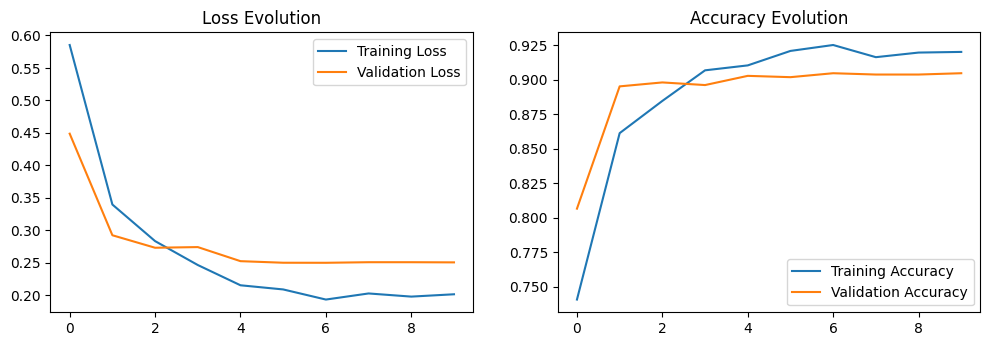

In [29]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(model_tl_final.history['loss'], label='Training Loss')
plt.plot(model_tl_final.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(model_tl_final.history['accuracy'], label='Training Accuracy')
plt.plot(model_tl_final.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [30]:
evaluation = model_tl.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model_tl.evaluate(train_generator_2)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

150/150 [==============================] - 875s 6s/step - loss: 0.5136 - accuracy: 0.8085
Test Accuracy: 80.85%
132/132 [==============================] - 752s 6s/step - loss: 0.1539 - accuracy: 0.9413
Train Accuracy: 94.13%


150/150 [==============================] - 917s 6s/step


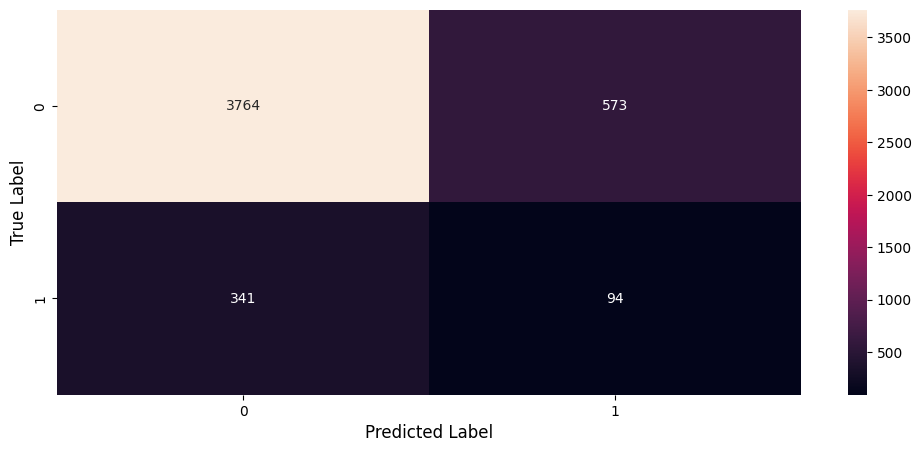

In [36]:
import seaborn as sns
y_true = test_generator.classes
y_pred = (model_tl.predict(test_generator) > 0.5).astype("int32")

from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12,5))

confusion_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [37]:
def summarize_classification(y_true, y_pred):
    
    acc = accuracy_score(y_true, y_pred, normalize=True)
    num_acc = accuracy_score(y_true, y_pred, normalize=False)

    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cr = metrics.classification_report(y_true, y_pred) # classificatiob report
    
    print("Test data count: ",len(y_true))
    print("accuracy_count : " , num_acc)
    print("accuracy_score : " , acc)
    print("precision_score : " , prec)
    print("recall_score : ", recall)
    print("class_report : ", cr)
    print()
     


In [38]:
summarize_classification(y_true, y_pred)

Test data count:  4772
accuracy_count :  3858
accuracy_score :  0.808466051969824
precision_score :  0.1409295352323838
recall_score :  0.2160919540229885
class_report :                precision    recall  f1-score   support

           0       0.92      0.87      0.89      4337
           1       0.14      0.22      0.17       435

    accuracy                           0.81      4772
   macro avg       0.53      0.54      0.53      4772
weighted avg       0.85      0.81      0.83      4772




In [31]:
from keras.utils import np_utils

In [33]:
model_tl_json = model_tl.to_json()

In [34]:
with open('melanoma_model_tl.json','w') as json_file:
    json_file.write(model_tl_json)

In [35]:
model_tl.save_weights('melanoma_model_tl.h5')
print("Saved model to disk.")

Saved model to disk.
